In [1]:
from eddy import rotationmap
import numpy as np

# Self-Gravity and Pressure Supported Disks

It is becoming ever apparent that the background motion in a disk is subtly perturbed away from a pure Keplerian profile of $v_{\phi} \propto r^{-0.5}$ due to either the background pressure support slowing the rotation (e.g., [Dullemond et al., 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.137D/abstract)) or the self-gravity of the disk hastening the rotation (e.g., [Veronesi et al., 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...914L..27V/abstract)). If the goal of your science is to better understand these properties then undertaking a full modeling of the $v_{\phi}$ profile is the best idea. However, if your goal is just to remove some average background profile to search for localized deviations then parameterization adopted in `eddy` might be worth a shot.

## Parameterization

For a 2D, purely Keplerian disk the rotation profile is given by

$$v_{\phi} = \sqrt{\frac{GM_*}{r}},$$

where $M_*$ is the dynamical mass of the central star. This can be modified to include an additional radial-dependent mass component, $M_d(r)$, that describe the disk mass _within_ cylindrical radius $r$ (we explain why we have adopted this simplification later on). This gives a modified rotation curve of

$$v_{\phi} = \sqrt{\frac{G(M_* + M_d(r))}{r}}.$$

Assuming a power-law surface density profile of the form, $\Sigma(r) = \Sigma_0 \times r^{-\gamma}$, then $M_d(r)$ is given by

$$M_d(r) = M_{\rm disk} \times \frac{r^{2 - \gamma} - r_{\rm in}^{2 - \gamma}}{r_{\rm out}^{2 - \gamma} - r_{\rm in}^{2 - \gamma}},$$

with $r_{\rm in}$ and $r_{\rm out}$ describing the disk inner and outer edge, respectively, and $M_{\rm disk}$ is the total disk mass. Note that for the commonly assumed $\gamma = 1$ case this is a simple linear interpolation between $r_{\rm in}$ and $r_{\rm out}$.

These parameters can be controlled with the parameter names `'mdisk'`, `'gamma'`, `'r_in'` and `'r_out'` (note here to differentiate these from the `'r_min'` and `'r_max'` parameter that describe the mask).

Although the parameterization described above was motivated by the need for a hastening of the disk's rotation due to the added gravitational potential of the disk, this functional form allows for a handy form to also account for the pressure support in the outer edge of the disk. This connection can most easily be seen when you consider the slowing of the disk as due to a radially dependent _negative_ disk mass.

With this interpretation you can broadly relate the parameters to properties of the pressure support:

* `'mdisk'` - Sets the magnitude of sub-Keplerian rotation. 
* `'r_in'` - Sets the radius where the rotation profile deviates from Keplerian rotation, likely the start of the exponential tail in the surface density profile.
* `'r_out`' - Sets the radius beyond which the rotation curve looks Keplerian again, but around a star with a reduced dynamical mass.
* `'gamma'` - Sets how quickly the velocity profile transforms between `'r_in'` and `'r_out'`.

This figure from Teague et al. (2022) shows how these parameters can be used to mimic a super-Keplerian (panels _a_, _b_, _d_ and _e_) and sub-Keplerian (panels _c_ and _f_) rotation curve where the black dashed line shows a purely Keplerian profile.

<img src="./analytical_deviations.png">


## Application to a Self Gravitating Disk

In [2]:
# coming soon

## Application to a Pressure Supported Disk

First we load up the data from Teague et al. (2022). The `v0` and `dv0` maps can be obtained from [**link coming soon**]. Note here we're using the `downsample` parameter to speed things up and setting a field of view of 8 arcseconds with the `FOV` argument.

Assuming uncertainties in ../../cubes/TWHYa_CO_21_dv0.fits.


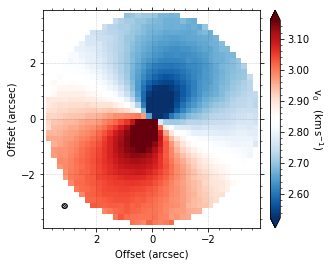

In [3]:
cube = rotationmap('../../cubes/TWHYa_CO_21_v0.fits', FOV=8.0, downsample='beam')
cube.plot_data()

To start we try and fit a simple Keplerian model. Remember to mask out those inner regions where beam smearing becomes an issue.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['2.04e-02', '1.77e-03', '1.52e+02', '8.06e-01', '2.84e+03']


100%|██████████| 1200/1200 [00:27<00:00, 44.23it/s]


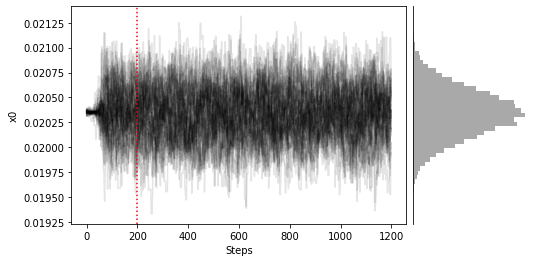

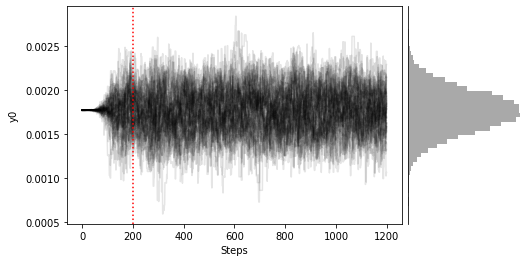

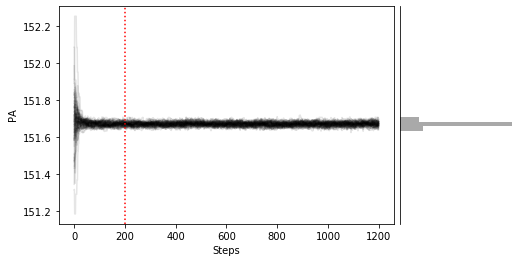

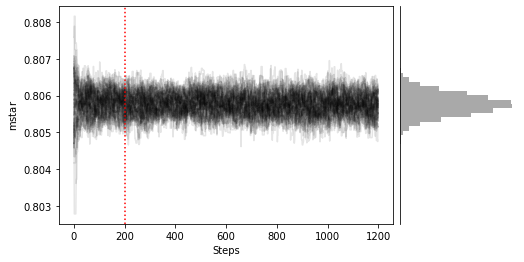

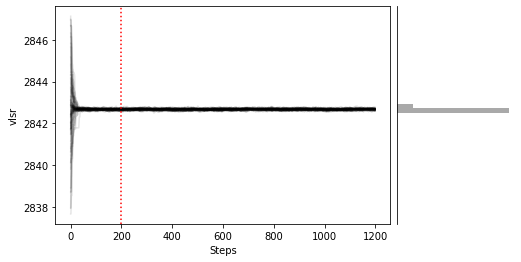

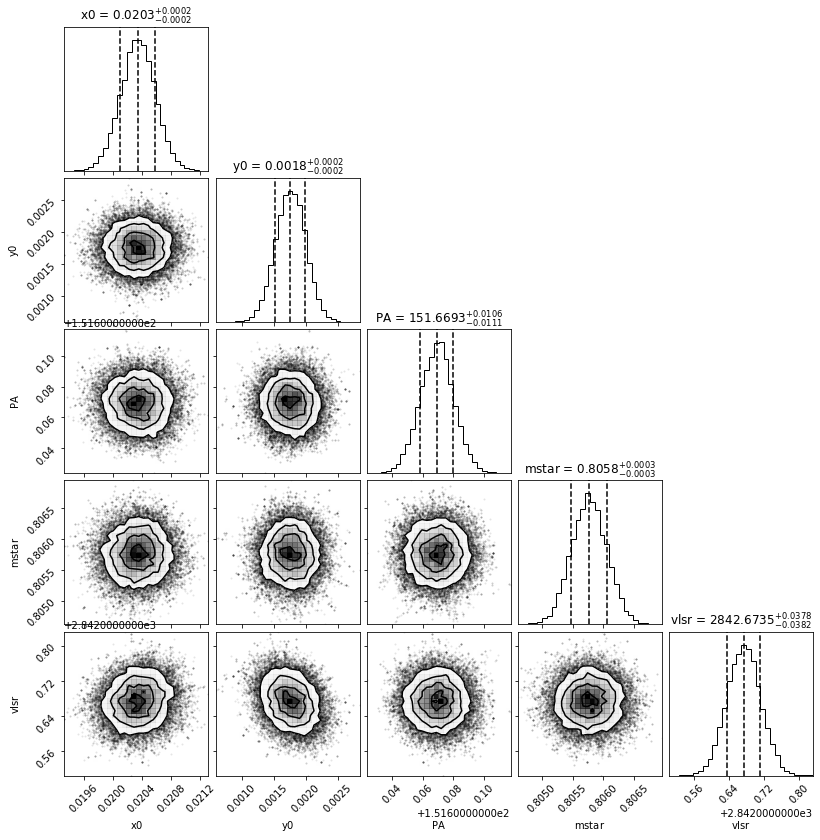

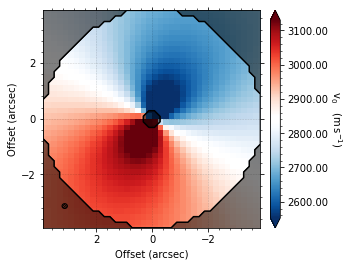

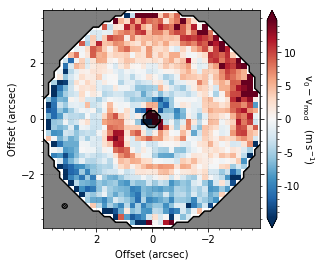

In [4]:
# Dictionary to contain the disk parameters.

params = {}

# Start with the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

# Provide starting guesses for these values.

p0 = [0.0, 0.0, 151., 0.81, 2.8e3]

# Fix the other parameters.

params['inc'] = 5.8
params['dist'] = 60.1
params['r_min'] = 2.0 * cube.bmaj

# Run the sampler.

samples = cube.fit_map(p0=p0, params=params, nwalkers=64, nburnin=200, nsteps=1000)

Although we get nice convergence of the walkers with seemingly independent posterior distributions, the residuals highlight that there's clearly some residual structure. Once major component is the large spiral arm which is discussed in the aforementioned paper. However, there's a clear red / blue residual along the major axis that can be attributed to sub-Keplerian rotation (see Fig. 5 in the Appendix of [Teague et al. 2019a](https://ui.adsabs.harvard.edu/abs/2019ApJ...884L..56T/abstract)).

To account for this structure we can use the parameterization described above. Here we set `'r_out'` to the disk outer edge, 4 arcseconds, as this should be the slowest part of the rotation.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr, r_in, gamma, mdisk].
Optimized starting positions:
	p0 = ['2.06e-02', '9.61e-04', '1.52e+02', '8.25e-01', '2.84e+03', '1.48e+00', '2.32e-01', '-1.58e-01']


100%|██████████| 2000/2000 [00:59<00:00, 33.83it/s]


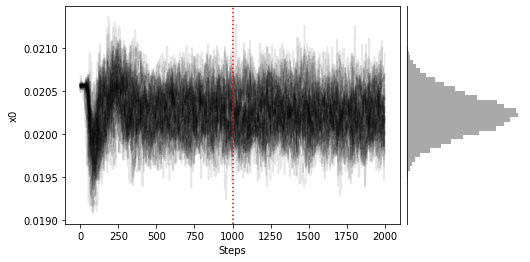

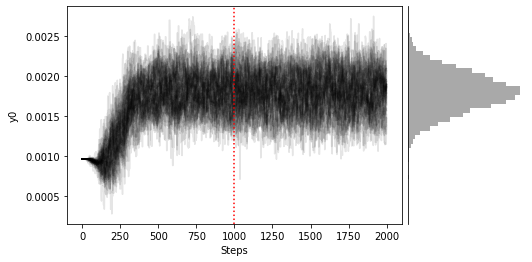

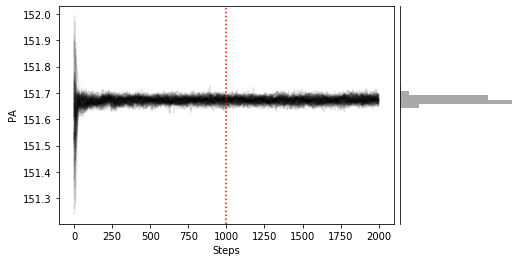

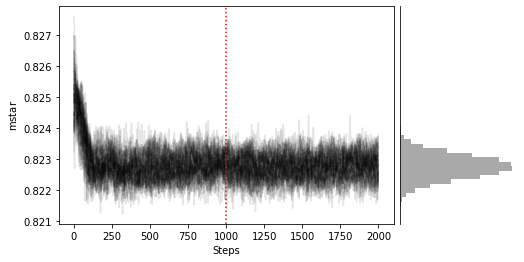

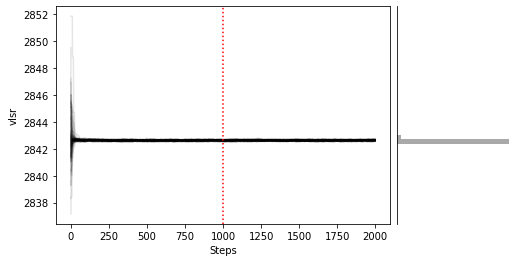

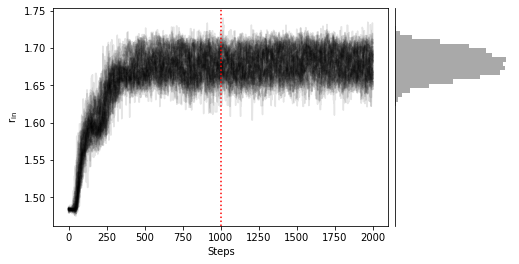

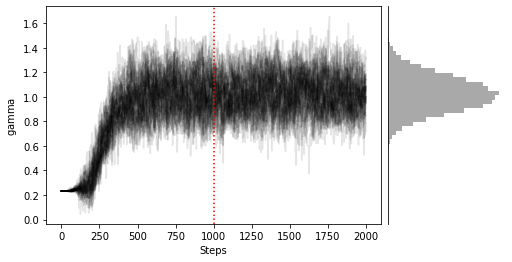

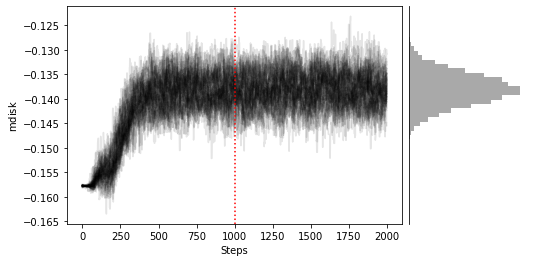

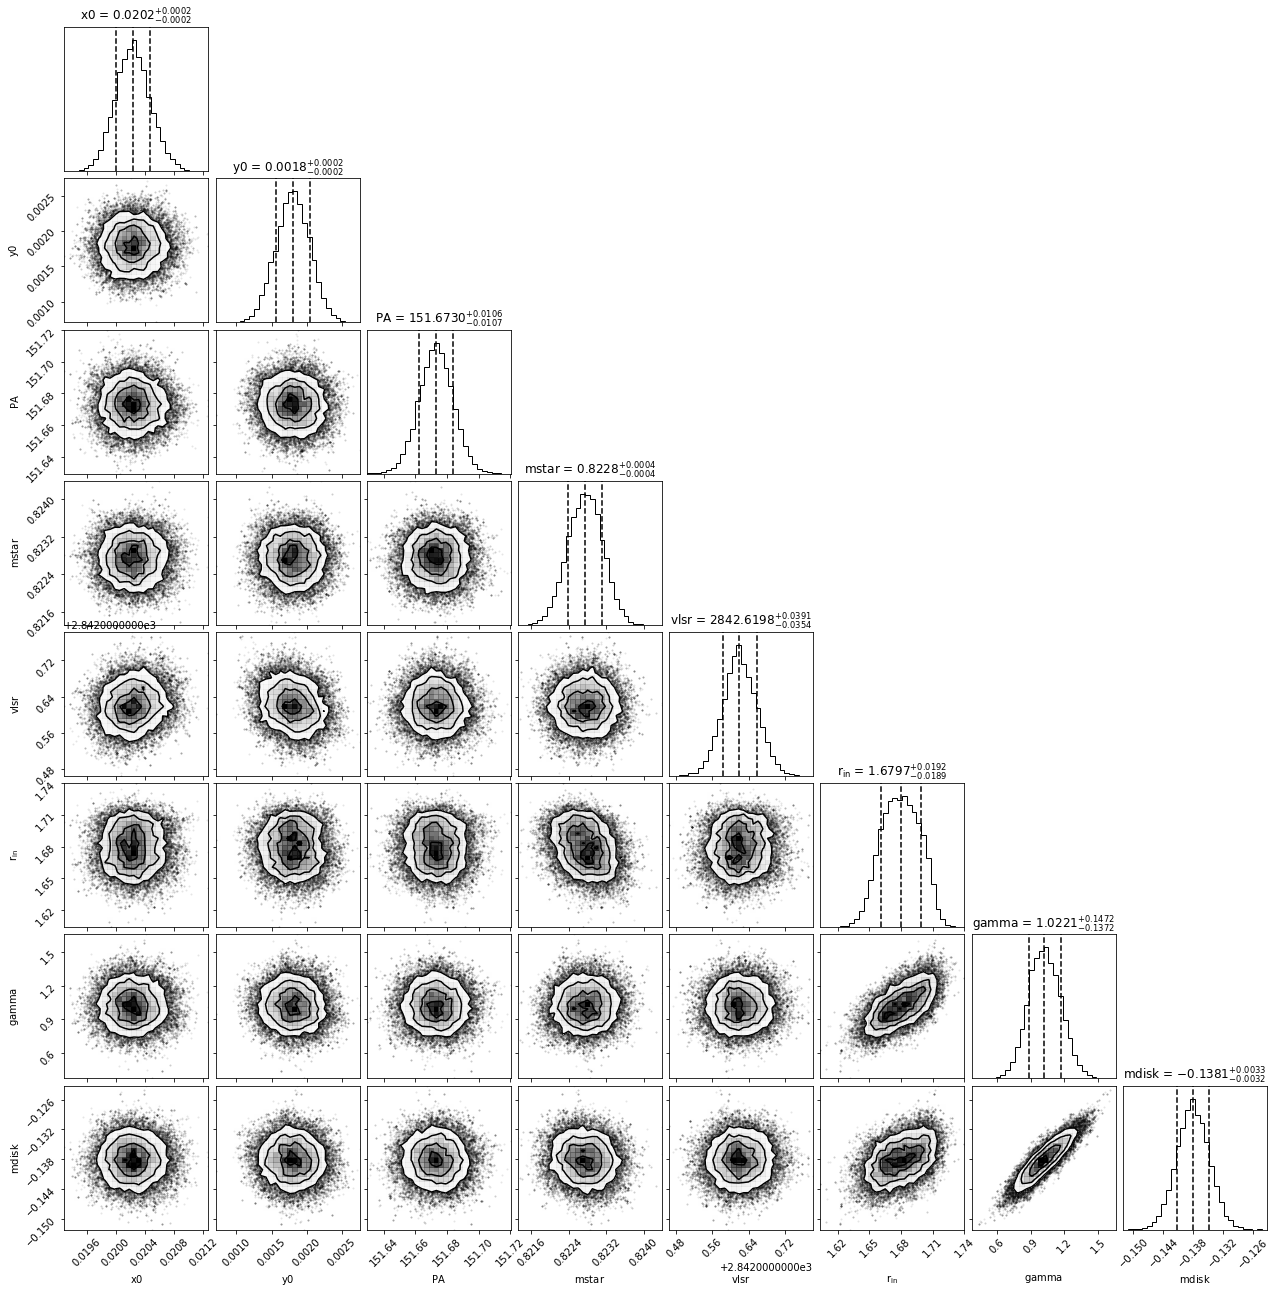

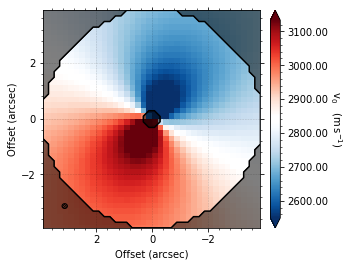

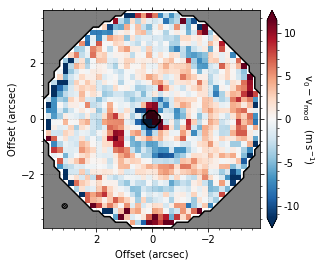

In [5]:
# Dictionary to contain the disk parameters.

params = {}

# Start with the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4
params['r_in'] = 5
params['gamma'] = 6
params['mdisk'] = 7

# Provide starting guesses for these values.

p0 = [0.0, 0.0, 151., 0.81, 2.8e3, 1.0, 1.0, 0.0]

# Fix the other parameters.

params['inc'] = 5.8
params['dist'] = 60.1
params['r_min'] = 2.0 * cube.bmaj
params['r_out'] = 4.0

# Run the sampler.

samples = cube.fit_map(p0=p0, params=params, nwalkers=64, nburnin=1000, nsteps=1000)

Clearly this does a much better job of removing those outer residuals and leaving a more prominent spiral pattern.